## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""

reduce_lr_factor = [0.5, 0.7, 0.9]
redice_lr_patient = [5, 10, 15]

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
import itertools
from keras.layers import BatchNormalization
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                 patience=reduce_patient, 
                                 verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 5s 106us/step - loss: 1.3149 - acc: 0.5416 - val_loss: 1.4766 - val_acc: 0.4837
Epoch 12/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.2922 - acc: 0.5497 - val_loss: 1.4713 - val_acc: 0.4849
Epoch 13/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.2694 - acc: 0.5586 - val_loss: 1.4554 - val_acc: 0.4855
Epoch 14/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.2477 - acc: 0.5673 - val_loss: 1.4634 - val_acc: 0.4848
Epoch 15/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.2275 - acc: 0.5740 - val_loss: 1.4454 - val_acc: 0.4941
Epoch 16/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2076 - acc: 0.5834 - val_loss: 1.4446 - val_acc: 0.4921
Epoch 17/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.1888 - acc: 0.5888 - val_loss: 1.4377 - val_acc: 0.4927
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 152us/step - loss: 2.2474 - acc: 0.2618 - val_loss: 2.2555 - val_acc: 0.2941
Epoch 2/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.7763 - acc: 0.3835 - val_loss: 1.8591 - val_acc: 0.3716
Epoch 3/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.6409 - acc: 0.4249 - val_loss: 1.6991 - val_acc: 0.4104
Epoch 4/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.5648 - acc: 0.4519 - val_loss: 1.6300 - val_acc: 0.4263
Epoch 5/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.5078 - acc: 0.4726 - val_loss: 1.6030 - val_acc: 0.4350
Epoch 6/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.4637 - acc: 0.4867 - val_loss: 1.5917 - val_acc: 0.4440
Epoch 7/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.4270 - acc: 0.4993 - val_loss: 1.5498 - 

Epoch 24/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.0601 - acc: 0.6367 - val_loss: 1.4338 - val_acc: 0.5031
Epoch 25/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.0443 - acc: 0.6449 - val_loss: 1.4316 - val_acc: 0.5031
Numbers of exp: 5, reduce_factor: 0.70, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

50000/50000 [==============================] - 5s 104us/step - loss: 1.3228 - acc: 0.5396 - val_loss: 1.5141 - val_acc: 0.4709
Epoch 12/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.2990 - acc: 0.5481 - val_loss: 1.4935 - val_acc: 0.4802
Epoch 13/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.2765 - acc: 0.5565 - val_loss: 1.4794 - val_acc: 0.4834
Epoch 14/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.2532 - acc: 0.5633 - val_loss: 1.4826 - val_acc: 0.4833
Epoch 15/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.2347 - acc: 0.5704 - val_loss: 1.4681 - val_acc: 0.4855
Epoch 16/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.2150 - acc: 0.5764 - val_loss: 1.4663 - val_acc: 0.4857
Epoch 17/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1970 - acc: 0.5850 - val_loss: 1.4626 - val_acc: 0.4871
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 131us/step - loss: 2.1886 - acc: 0.2784 - val_loss: 2.4295 - val_acc: 0.2816
Epoch 2/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.7567 - acc: 0.3909 - val_loss: 1.8166 - val_acc: 0.3725
Epoch 3/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.6238 - acc: 0.4336 - val_loss: 1.7116 - val_acc: 0.4033
Epoch 4/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.5523 - acc: 0.4597 - val_loss: 1.6520 - val_acc: 0.4256
Epoch 5/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.4977 - acc: 0.4798 - val_loss: 1.5920 - val_acc: 0.4442
Epoch 6/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.4540 - acc: 0.4917 - val_loss: 1.5881 - val_acc: 0.4467
Epoch 7/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.4166 - acc: 0.5067 - val_loss: 1.5721 - 


Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 23/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.4398 - acc: 0.8733 - val_loss: 1.5181 - val_acc: 0.5331
Epoch 24/25
50000/50000 [==============================] - 6s 110us/step - loss: 0.4225 - acc: 0.8815 - val_loss: 1.5351 - val_acc: 0.5324
Epoch 25/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.4118 - acc: 0.8858 - val_loss: 1.5746 - val_acc: 0.5286
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)      

Epoch 10/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.0677 - acc: 0.6322 - val_loss: 1.4170 - val_acc: 0.4967
Epoch 11/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.0347 - acc: 0.6456 - val_loss: 1.4404 - val_acc: 0.4851
Epoch 12/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.0042 - acc: 0.6549 - val_loss: 1.5073 - val_acc: 0.4750
Epoch 13/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.9785 - acc: 0.6656 - val_loss: 1.4387 - val_acc: 0.4972
Epoch 14/25
50000/50000 [==============================] - 6s 112us/step - loss: 0.9514 - acc: 0.6776 - val_loss: 1.4591 - val_acc: 0.4951
Epoch 15/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.9238 - acc: 0.6866 - val_loss: 1.4525 - val_acc: 0.4958
Epoch 16/25
50000/50000 [==============================] - 6s 112us/step - loss: 0.8966 - acc: 0.6958 - val_loss: 1.4744 - val_acc: 0.4938
Epoch 17/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.9508 - acc: 0.3382 - val_loss: 1.8860 - val_acc: 0.3556
Epoch 2/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.5906 - acc: 0.4422 - val_loss: 1.6697 - val_acc: 0.4145
Epoch 3/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.4895 - acc: 0.4783 - val_loss: 1.6416 - val_acc: 0.4237
Epoch 4/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.4260 - acc: 0.5010 - val_loss: 1.5753 - val_acc: 0.4457
Epoch 5/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.3772 - acc: 0.5174 - val_loss: 1.5609 - val_acc: 0.4487
Epoch 6/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.3362 - acc: 0.5340 - val_loss: 1.5322 - val_acc: 0.4616
Epoch 7/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.3017 - acc: 0.5464 - val_loss: 1.4860 - 

Epoch 24/25
50000/50000 [==============================] - 6s 112us/step - loss: 0.9777 - acc: 0.6731 - val_loss: 1.4450 - val_acc: 0.4923
Epoch 25/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.9669 - acc: 0.6772 - val_loss: 1.4183 - val_acc: 0.5062
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

Epoch 11/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.2384 - acc: 0.5682 - val_loss: 1.4599 - val_acc: 0.4860
Epoch 12/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.2157 - acc: 0.5789 - val_loss: 1.4622 - val_acc: 0.4818
Epoch 13/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.1963 - acc: 0.5841 - val_loss: 1.4675 - val_acc: 0.4822
Epoch 14/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.1782 - acc: 0.5900 - val_loss: 1.4680 - val_acc: 0.4840
Epoch 15/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.1593 - acc: 0.5985 - val_loss: 1.4533 - val_acc: 0.4912
Epoch 16/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.1410 - acc: 0.6070 - val_loss: 1.4516 - val_acc: 0.4916
Epoch 17/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.1252 - acc: 0.6118 - val_loss: 1.4556 - val_acc: 0.4917
Epoch 18/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.8560 - acc: 0.3636 - val_loss: 2.5595 - val_acc: 0.2622
Epoch 2/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.5476 - acc: 0.4548 - val_loss: 2.1176 - val_acc: 0.3152
Epoch 3/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.4283 - acc: 0.4974 - val_loss: 2.1382 - val_acc: 0.3086
Epoch 4/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.3571 - acc: 0.5212 - val_loss: 2.0925 - val_acc: 0.3076
Epoch 5/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.2864 - acc: 0.5446 - val_loss: 2.0259 - val_acc: 0.3536
Epoch 6/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.2341 - acc: 0.5652 - val_loss: 2.0112 - val_acc: 0.3332
Epoch 7/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.1785 - acc: 0.5852 - val_loss: 2.0640 - 

Epoch 23/25
50000/50000 [==============================] - 7s 137us/step - loss: 0.5558 - acc: 0.8261 - val_loss: 1.6925 - val_acc: 0.4717
Epoch 24/25
50000/50000 [==============================] - 7s 134us/step - loss: 0.5359 - acc: 0.8327 - val_loss: 1.5761 - val_acc: 0.5052
Epoch 25/25
50000/50000 [==============================] - 6s 112us/step - loss: 0.5128 - acc: 0.8422 - val_loss: 1.6289 - val_acc: 0.4978
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_____________________________________________________________

50000/50000 [==============================] - 6s 121us/step - loss: 1.0833 - acc: 0.6267 - val_loss: 1.5793 - val_acc: 0.4529
Epoch 11/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.0494 - acc: 0.6394 - val_loss: 1.5724 - val_acc: 0.4568
Epoch 12/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.0181 - acc: 0.6506 - val_loss: 1.5507 - val_acc: 0.4763
Epoch 13/25
50000/50000 [==============================] - 6s 126us/step - loss: 0.9865 - acc: 0.6623 - val_loss: 1.6872 - val_acc: 0.4422
Epoch 14/25
50000/50000 [==============================] - 7s 134us/step - loss: 0.9551 - acc: 0.6715 - val_loss: 1.6453 - val_acc: 0.4539
Epoch 15/25
50000/50000 [==============================] - 6s 123us/step - loss: 0.9269 - acc: 0.6844 - val_loss: 1.6105 - val_acc: 0.4613
Epoch 16/25
50000/50000 [==============================] - 6s 119us/step - loss: 0.8983 - acc: 0.6944 - val_loss: 1.6309 - val_acc: 0.4477
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 199us/step - loss: 2.0391 - acc: 0.3098 - val_loss: 2.0456 - val_acc: 0.3255
Epoch 2/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.7056 - acc: 0.4054 - val_loss: 1.8742 - val_acc: 0.3565
Epoch 3/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.5856 - acc: 0.4425 - val_loss: 1.7324 - val_acc: 0.4025
Epoch 4/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.5038 - acc: 0.4742 - val_loss: 1.6713 - val_acc: 0.4084
Epoch 5/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4460 - acc: 0.4943 - val_loss: 1.6238 - val_acc: 0.4291
Epoch 6/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.3964 - acc: 0.5121 - val_loss: 1.5579 - val_acc: 0.4537
Epoch 7/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.3532 - acc: 0.5289 - val_loss: 1.5691 -

50000/50000 [==============================] - 6s 115us/step - loss: 0.9635 - acc: 0.6765 - val_loss: 1.5232 - val_acc: 0.4747
Epoch 24/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.9449 - acc: 0.6848 - val_loss: 1.4807 - val_acc: 0.4946
Epoch 25/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.9307 - acc: 0.6884 - val_loss: 1.4780 - val_acc: 0.4893
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_

50000/50000 [==============================] - 6s 115us/step - loss: 1.2709 - acc: 0.5587 - val_loss: 1.5401 - val_acc: 0.4599
Epoch 11/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.2415 - acc: 0.5718 - val_loss: 1.5028 - val_acc: 0.4671
Epoch 12/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.2136 - acc: 0.5794 - val_loss: 1.5071 - val_acc: 0.4742
Epoch 13/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.1881 - acc: 0.5898 - val_loss: 1.5332 - val_acc: 0.4665
Epoch 14/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.1649 - acc: 0.5999 - val_loss: 1.5020 - val_acc: 0.4720
Epoch 15/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.1392 - acc: 0.6084 - val_loss: 1.5417 - val_acc: 0.4681
Epoch 16/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.1173 - acc: 0.6175 - val_loss: 1.5137 - val_acc: 0.4696
Epoch 17/25
50000/50000 [==============

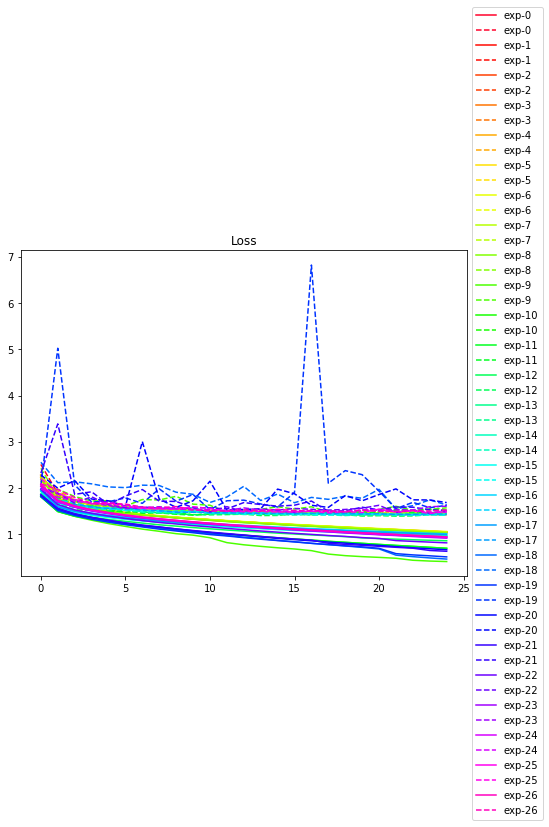

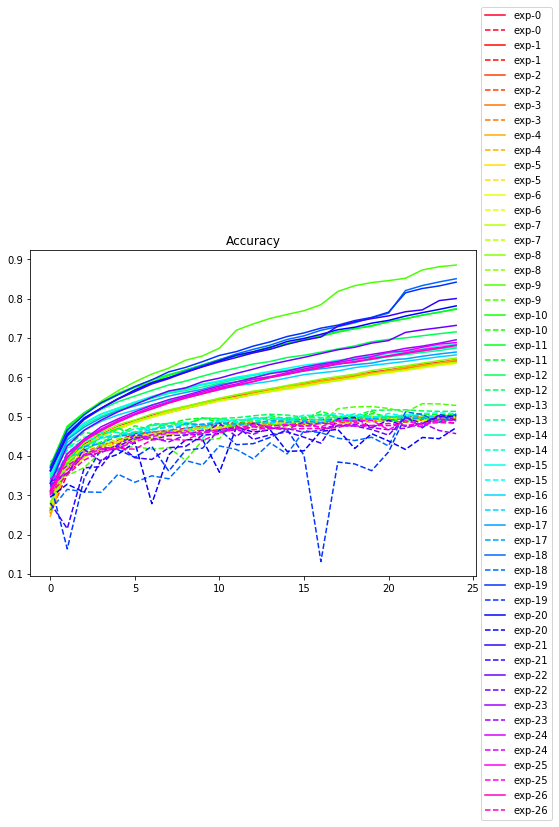

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()